In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [47]:
data = pd.read_csv("Pulsar.csv")
data.shape

(17898, 9)

In [48]:
data.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [49]:
data.groupby(['Class']).count()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
Class,,,,,,,,
0,16259,16259,16259,16259,16259,16259,16259,16259
1,1639,1639,1639,1639,1639,1639,1639,1639


In [50]:
data = data.interpolate()

In [51]:
train_y = data['Class']
train_x = data.drop(['Class'], axis=1)

In [39]:
from sklearn.metrics import confusion_matrix
def plot_conf_mat(conf_mat):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(conf_mat,
                     annot=True,
                     cbar=False,
                     fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

In [42]:
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
rf_model = RandomForestClassifier(n_estimators=700, min_samples_split=2, min_samples_leaf=2, bootstrap=True)
et_model = ExtraTreesClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=2, bootstrap=True, max_depth=20)
rf_model.fit(train_x, train_y)
et_model.fit(train_x, train_y)

SVC()

In [52]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)
train_x = train_x.values
val_x = val_x.values
train_x.shape

(16108, 8)

In [53]:
predictions = rf_model.predict(val_x)
confusion_matrix(val_y, predictions)

C:\Users\gilad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[1652,    1],
       [  12,  125]], dtype=int64)

In [54]:
predictions = et_model.predict(val_x)
confusion_matrix(val_y, predictions)

C:\Users\gilad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


array([[1649,    4],
       [  16,  121]], dtype=int64)

In [55]:
print(classification_report(val_y, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1653
           1       0.97      0.88      0.92       137

    accuracy                           0.99      1790
   macro avg       0.98      0.94      0.96      1790
weighted avg       0.99      0.99      0.99      1790



In [73]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [75]:
naive_model = GaussianNB()
naive_model.fit(train_x, train_y)
predictions = naive_model.predict(val_x)
confusion_matrix(val_y, predictions)

array([[1594,   59],
       [  20,  117]], dtype=int64)

In [100]:
neighbors_model = KNeighborsClassifier(n_neighbors=5)
neighbors_model.fit(train_x, train_y)
predictions = neighbors_model.predict(val_x)
confusion_matrix(val_y, predictions)

array([[1644,    9],
       [  27,  110]], dtype=int64)

In [94]:
logistic_model = LogisticRegression(max_iter=5000, C=1, penalty='l1', solver='liblinear')
logistic_model.fit(train_x, train_y)
predictions = logistic_model.predict(val_x)
confusion_matrix(val_y, predictions)

array([[1645,    8],
       [  20,  117]], dtype=int64)

# Hierarchical Classification

In [15]:
def select_predictions(x_test, y_test, predict, trusted_tags):
    trusted_pred = [(y, pred) for (y, pred) in zip(y_test, predict)
                    if pred in trusted_tags]
    untrusted_pred = [(x, y) for (x, y, pred) in zip(x_test, y_test, predict)
                      if pred not in trusted_tags]
    return trusted_pred, untrusted_pred

In [16]:
def hierarchical_classifying(models, trusted_tags_array, x_test, y_test):
    chained_x_test, chained_y_test = x_test, y_test
    new_y_test, new_predict = [], []
    for index, model in enumerate(models[:-1]):
        predict = model.predict(chained_x_test)
        trusted_pred, untrusted_pred = select_predictions(chained_x_test, chained_y_test,
                                                          predict, trusted_tags_array[index])
        new_y_test += [item[0] for item in trusted_pred]
        new_predict += [item[1] for item in trusted_pred]

        chained_x_test = [item[0] for item in untrusted_pred]
        chained_y_test = [item[1] for item in untrusted_pred]


    last_model_predict = models[-1].predict(chained_x_test)
    new_y_test += chained_y_test
    new_predict += last_model_predict.tolist()

    print(classification_report(new_y_test, new_predict))
    conf_mat = confusion_matrix(new_y_test, new_predict)
    plot_conf_mat(conf_mat)

C:\Users\gilad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\gilad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1653
           1       0.97      0.92      0.94       137

    accuracy                           0.99      1790
   macro avg       0.98      0.96      0.97      1790
weighted avg       0.99      0.99      0.99      1790



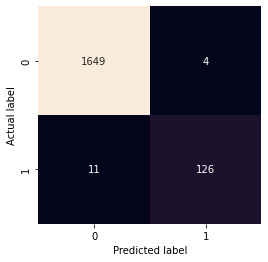

In [17]:
rf_trusted_tags = [1]
trusted_tags_array = [rf_trusted_tags]

models = [rf_model, et_model]
x_test = [val_x[i] for i in range(val_x.shape[0])]
y_test = val_y.tolist()
hierarchical_classifying(models, trusted_tags_array, x_test, y_test)

# AutoEncoder

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical

In [106]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

input_dim = train_x.shape[1]
encoding_dim = 50

model = Sequential()
model.add(Dense(encoding_dim, activation="tanh", input_shape=(input_dim,)))
model.add(Dense(int(encoding_dim / 2), activation="relu"))
model.add(Dense(int(encoding_dim / 2), activation='tanh'))
model.add(Dense(input_dim, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 208       
Total params: 2,583
Trainable params: 2,583
Non-trainable params: 0
_________________________________________________________________


In [105]:
early_stop = EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [106]:
nb_epoch = 20
batch_size = 32

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(val_x, val_x),
                    verbose=1,
                    callbacks=[checkpoint, early_stop])

autoencoder = model

Epoch 1/20
504/504 [==============================] - 4s 7ms/step - loss: 4337.9414 - acc: 0.5944 - val_loss: 4045.4146 - val_acc: 0.5872

Epoch 00001: val_acc improved from -inf to 0.58715, saving model to saved_models\best_conf.ckpt
Epoch 2/20
 70/504 [===>..........................] - ETA: 2s - loss: 3835.4727 - acc: 0.5795

KeyboardInterrupt: 

In [107]:
model.load_weights("saved_models/best_conf.ckpt")

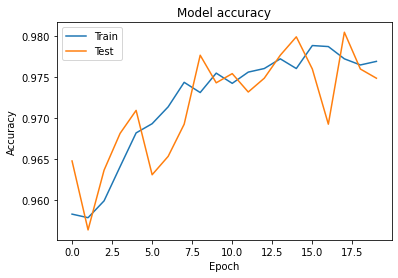

In [108]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [149]:
predictions = autoencoder.predict(val_x)
print(predictions.shape)

mse = np.mean(np.power(val_x - predictions, 2), axis=1)
print(mse.shape)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': val_y})
error_df.head()

(1664, 8)
(1664, 8)
(1664,)


,reconstruction_error,true_class
0,1.537575,0
1,3.700333,0
2,13.917394,0
3,9.935419,0
4,216.554345,0


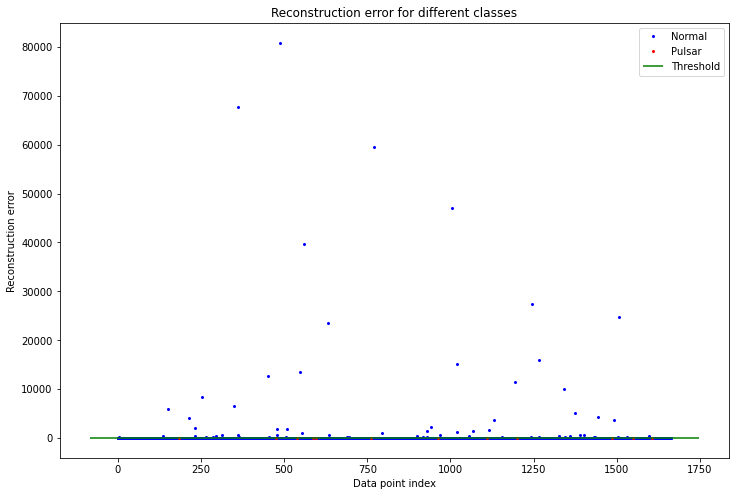

In [154]:
threshold = 10

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label="Pulsar" if name == 1 else "Normal",
            color="red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [155]:
normal = error_df[error_df.true_class == 0]
pulsar = error_df[error_df.true_class == 1]

print('Normal stars: %d, Pulsars stars: %d' % (len(normal), len(pulsar)))

Normal stars: 1652, Pulsars stars: 12


In [156]:
true_positives = len(pulsar[pulsar.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(pulsar[pulsar.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 4, true negatives: 1210
False positives: 442, false negatives: 8


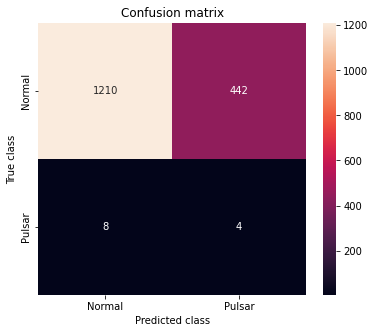

In [157]:
labels = ["Normal", "Pulsar"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [101]:
train_y = data['Class']
train_x = data.drop(['Class'], axis=1)

In [102]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)
train_x = train_x.values
val_x = val_x.values
train_x.shape

(16108, 8)

In [107]:
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)

In [108]:
input_dim = train_x.shape[1]

model = Sequential()
model.add(Dense(100, input_shape=(input_dim,)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               900       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [110]:
early_stop = EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [111]:
nb_epoch = 50
batch_size = 32

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_x, train_y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(val_x, val_y),
                    verbose=1,
                    callbacks=[checkpoint, early_stop])

autoencoder = model

Epoch 1/50
504/504 [==============================] - 5s 4ms/step - loss: 0.1333 - acc: 0.9654 - val_loss: 0.0754 - val_acc: 0.9771

Epoch 00001: val_acc improved from -inf to 0.97709, saving model to saved_models\best_conf.ckpt
Epoch 2/50
504/504 [==============================] - 2s 4ms/step - loss: 0.0938 - acc: 0.9712 - val_loss: 0.0717 - val_acc: 0.9793

Epoch 00002: val_acc improved from 0.97709 to 0.97933, saving model to saved_models\best_conf.ckpt
Epoch 3/50
504/504 [==============================] - 2s 4ms/step - loss: 0.0889 - acc: 0.9737 - val_loss: 0.0647 - val_acc: 0.9832

Epoch 00003: val_acc improved from 0.97933 to 0.98324, saving model to saved_models\best_conf.ckpt
Epoch 4/50
504/504 [==============================] - 2s 5ms/step - loss: 0.0837 - acc: 0.9751 - val_loss: 0.0674 - val_acc: 0.9844

Epoch 00004: val_acc improved from 0.98324 to 0.98436, saving model to saved_models\best_conf.ckpt
Epoch 5/50
504/504 [==============================] - 2s 4ms/step - loss: 0

In [114]:
model.load_weights("saved_models/best_conf.ckpt")

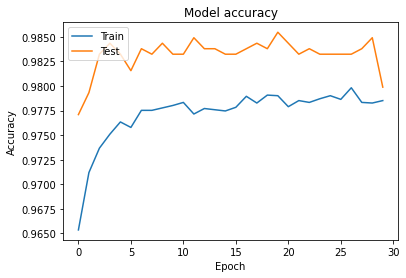

In [115]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [116]:
predictions = model.predict(val_x)
pred_y = np.argmax(predictions, axis=1)

actual_y = np.argmax(val_y, axis=1)

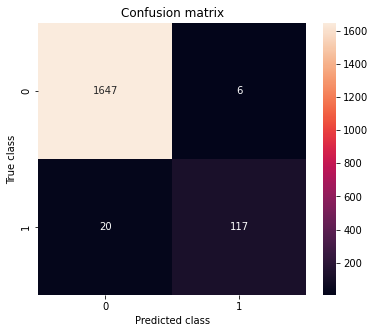

In [118]:
conf_matrix = confusion_matrix(actual_y, pred_y)
labels = "01"

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
def high_recall_score(predictions):
    pass

In [16]:
train_y = data['Class']
train_x = data.drop(['Class'], axis=1)

In [9]:
def plot_conf_mat(conf_mat):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(conf_mat,
                     annot=True,
                     cbar=False,
                     fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

In [10]:
# Take a classification model function, it's name as string
# and fit it to the current shuffeled data on x_train, x_test, y_train, y_test
def fit_and_print(model, name):
    global train_x, train_y
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)
    model.fit(train_x, train_y)
    predict = model.predict(test_x)
    print(f"============={name}=============")
    print(f'classification report: \n')
    print(f'{classification_report(test_y, predict)}\n\n\n')

    con_mat = confusion_matrix(test_y, predict)
    plot_conf_mat(con_mat)

In [22]:
from sklearn.model_selection import RandomizedSearchCV
def general_parameter_tuning(model, model_name, parameters):
    global train_x, train_y
    random_search = RandomizedSearchCV(estimator=model, scoring='precision',
                                       param_distributions=parameters,
                                       n_iter=10, cv=3, verbose=2,
                                       random_state=42)

    # Fit the random search model
    random_search.fit(train_x, train_y)
    print(random_search.best_params_)
    fit_and_print(random_search, model_name, )

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   5.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=511; total time=  21.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=511; total time=  20.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=511; total time=  18.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5

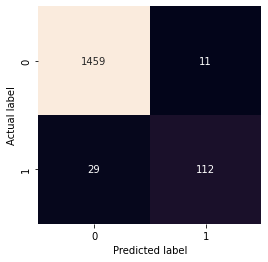

In [23]:
def random_forest_parameters_tuning():
    n_estimators = [int(x) for x in np.linspace(start=200, stop=1600, num=10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    model = RandomForestClassifier()

    general_parameter_tuning(model, "Random Forest", random_grid)

random_forest_parameters_tuning()

In [33]:
model = RandomForestClassifier(n_estimators=1400, min_samples_split=5,
                               min_samples_leaf=1, max_features='sqrt',
                               max_depth=30, bootstrap=True)

=============Random Forest=============
classification report: 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1470
           1       0.93      0.80      0.86       141

    accuracy                           0.98      1611
   macro avg       0.96      0.90      0.93      1611
weighted avg       0.98      0.98      0.98      1611






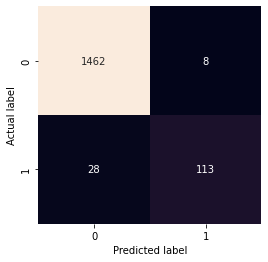

In [34]:
fit_and_print(model, "Random Forest")

=============Random Forest=============
classification report: 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1653
           1       0.95      0.85      0.90       137

    accuracy                           0.99      1790
   macro avg       0.97      0.93      0.95      1790
weighted avg       0.99      0.99      0.99      1790






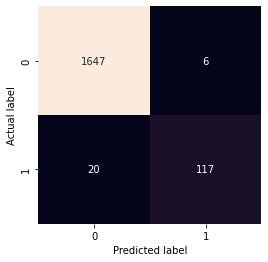

In [12]:
model = RandomForestClassifier(n_estimators=2000, min_samples_split=5,
                               min_samples_leaf=2, max_features='auto',
                               max_depth=50, bootstrap=True)
fit_and_print(model, "Random Forest")

In [17]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)
train_x = train_x.values
val_x = val_x.values

In [120]:
model = RandomForestClassifier(n_estimators=2000, min_samples_split=5,
                               min_samples_leaf=2, max_features='auto',
                               max_depth=50, bootstrap=True)
model.fit(train_x, train_y)

RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=2000)

In [121]:
from sklearn.metrics import recall_score, make_scorer
predicted = model.predict(val_x)
recall_score(val_y, predicted)

ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [ ]:
con_mat = confusion_matrix(val_y, predicted)
plot_conf_mat(con_mat)

In [ ]:
print(f'{classification_report(val_y, predicted)}\n\n\n')

In [ ]:
{'n_estimators': 822, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}